In [ ]:
%%capture
!pip install ydata-profiling


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport

In [12]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [13]:
train_df.head()

,id,player_id,friend_count,social_interactions,guild_membership,event_participation_rate,daily_login_streak,avg_session_length,sessions_per_week,total_playtime_hours,...,purchase_frequency,payment_methods_used,purchases_on_discount,discount_rate_used,seasonal_spending_pattern,owns_limited_edition,competitive_rank,tournament_participation,segment,spending_30d
0,PLY00001,P007453,140.0,39.0,NaN,35.495321,86.0,94.186687,20.660400,793.043827,...,NaN,1.0,1.0,0.250000,4.0,NaN,7.0,1.0,1.0,0.00
1,PLY00002,P120776,126.0,12.0,1.0,35.222611,27.0,76.694036,15.112974,836.397667,...,11.193590,1.0,25.0,0.581395,5.0,0.0,3.0,0.0,1.0,0.00
2,PLY00003,P083055,157.0,63.0,1.0,54.291374,1.0,66.680997,13.770480,561.212807,...,5.175272,3.0,27.0,0.551020,7.0,0.0,5.0,0.0,1.0,0.00
3,PLY00004,P087827,89.0,96.0,1.0,52.990011,74.0,75.864572,11.941930,NaN,...,10.374656,2.0,22.0,0.536585,6.0,0.0,9.0,0.0,2.0,2223.70
4,PLY00005,P045133,159.0,80.0,0.0,78.586509,84.0,33.774836,1.405901,617.041867,...,NaN,3.0,11.0,0.261905,0.0,1.0,4.0,0.0,3.0,156634.22


In [ ]:
train_df.info()

Note: จากการดู info เห็นได้ว่ามี missing values ทุก feature และเป็น missing ที่เกิดขึ้นแบบสุ่ม ไม่ได้มีนัยสำคัญ MCAR

Handle: [Simple Imputer (median), KNN Imputer, Iterative Imputer] <- ต้องทดลอง

In [ ]:
def is_real_float(x):
    if pd.isna(x):
        return True
    try:
        return int(x) != float(x)
    except:
        print(x)
        return False

In [42]:
print("=== REAL FLOAT COLUMNS ===")
for col in train_df.drop(columns=['id', 'player_id']).columns:
    if(train_df[col].apply(is_real_float).all()):
        print(col)

=== REAL FLOAT COLUMNS ===
event_participation_rate
avg_session_length
sessions_per_week
total_playtime_hours
days_since_last_login
historical_spending
prev_month_spending
avg_transaction_value
days_since_last_purchase
purchase_frequency


In [56]:
def is_categorical(column, threshold=20):
    n_unique = column.nunique()
    unique = column.unique()
    if (n_unique <= threshold):
        print(col, ":", n_unique)
        print(unique)
    return n_unique <= threshold

In [57]:
print("=== CATEGORICAL COLUMNS ===")
for col in train_df.drop(columns=['id', 'player_id']).columns:
    is_categorical(train_df[col])

=== CATEGORICAL COLUMNS ===
guild_membership : 2
[nan  1.  0.]
vip_status : 6
[ 0.  3.  1.  2.  4.  5. nan]
is_premium_member : 2
[ 0.  1. nan]
primary_game : 5
[ 0.  3. nan  4.  1.  2.]
games_played : 5
[ 4.  1.  2. nan  3.  5.]
platform : 3
[ 0.  1.  2. nan]
payment_methods_used : 5
[ 1.  3.  2. nan  4.  5.]
seasonal_spending_pattern : 12
[ 4.  5.  7.  6.  0. 10.  3.  8.  1.  2.  9. 11. nan]
owns_limited_edition : 2
[nan  0.  1.]
competitive_rank : 10
[ 7.  3.  5.  9.  4.  6.  2.  8. 10.  1. nan]
tournament_participation : 2
[ 1.  0. nan]
segment : 4
[ 1.  2.  3.  0. nan]


---

Note:

real category:
- guild_membership
- is_premium_member
- primary_game
- platform
- owns_limited_edition
- tournament_participation
- segment

ordinal category:
- vip_status
- games_played
- payment_methods_used
- seasonal_spending_pattern (Cyclical)
- competitive_rank

# Type Casting

In [61]:
float_columns = ['event_participation_rate', 'avg_session_length', 'sessions_per_week', 'total_playtime_hours', 'days_since_last_login',
'historical_spending', 'prev_month_spending', 'avg_transaction_value', 'days_since_last_purchase', 'purchase_frequency']

cat_columns = ['guild_membership', 'is_premium_member', 'primary_game', 'platform', 'owns_limited_edition', 'tournament_participation', 'segment']

In [62]:
# Cast categorical columns
for col in cat_columns:
    train_df[col] = train_df[col].astype('category')
    test_df[col] = test_df[col].astype('category')

# Cast float columns (ไว้เป็น float)
for col in float_columns:
    train_df[col] = train_df[col].astype('float64')
    test_df[col] = test_df[col].astype('float64')

# Cast ที่เหลือเป็น int
all_columns = set(train_df.select_dtypes(include=['float64']).columns)
exclude_columns = set(float_columns + cat_columns + ['spending_30d'])  # เผื่อ target เป็น float
int_columns = all_columns - exclude_columns

for col in int_columns:
    train_df[col] = train_df[col].fillna(-1).astype('int64')
    test_df[col] = test_df[col].fillna(-1).astype('int64')

In [63]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104000 entries, 0 to 103999
Data columns (total 35 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   id                           104000 non-null  object  
 1   player_id                    104000 non-null  object  
 2   friend_count                 104000 non-null  int64   
 3   social_interactions          104000 non-null  int64   
 4   guild_membership             97972 non-null   category
 5   event_participation_rate     97999 non-null   float64 
 6   daily_login_streak           104000 non-null  int64   
 7   avg_session_length           97972 non-null   float64 
 8   sessions_per_week            97838 non-null   float64 
 9   total_playtime_hours         97868 non-null   float64 
 10  days_since_last_login        97960 non-null   float64 
 11  achievement_count            104000 non-null  int64   
 12  achievement_completion_rate  104000 non-null

# Profiling

In [68]:
profile = ProfileReport(train_df, title="Train Data Profiling Report")

In [69]:
profile.to_file("trainReport.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:00<00:00, 37.15it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Note:

- Log Transform on [historical_spending, prev_month_spending, avg_transaction_value]
- Log Transform on target (spending_30d) log1p

# Correlation Matrix

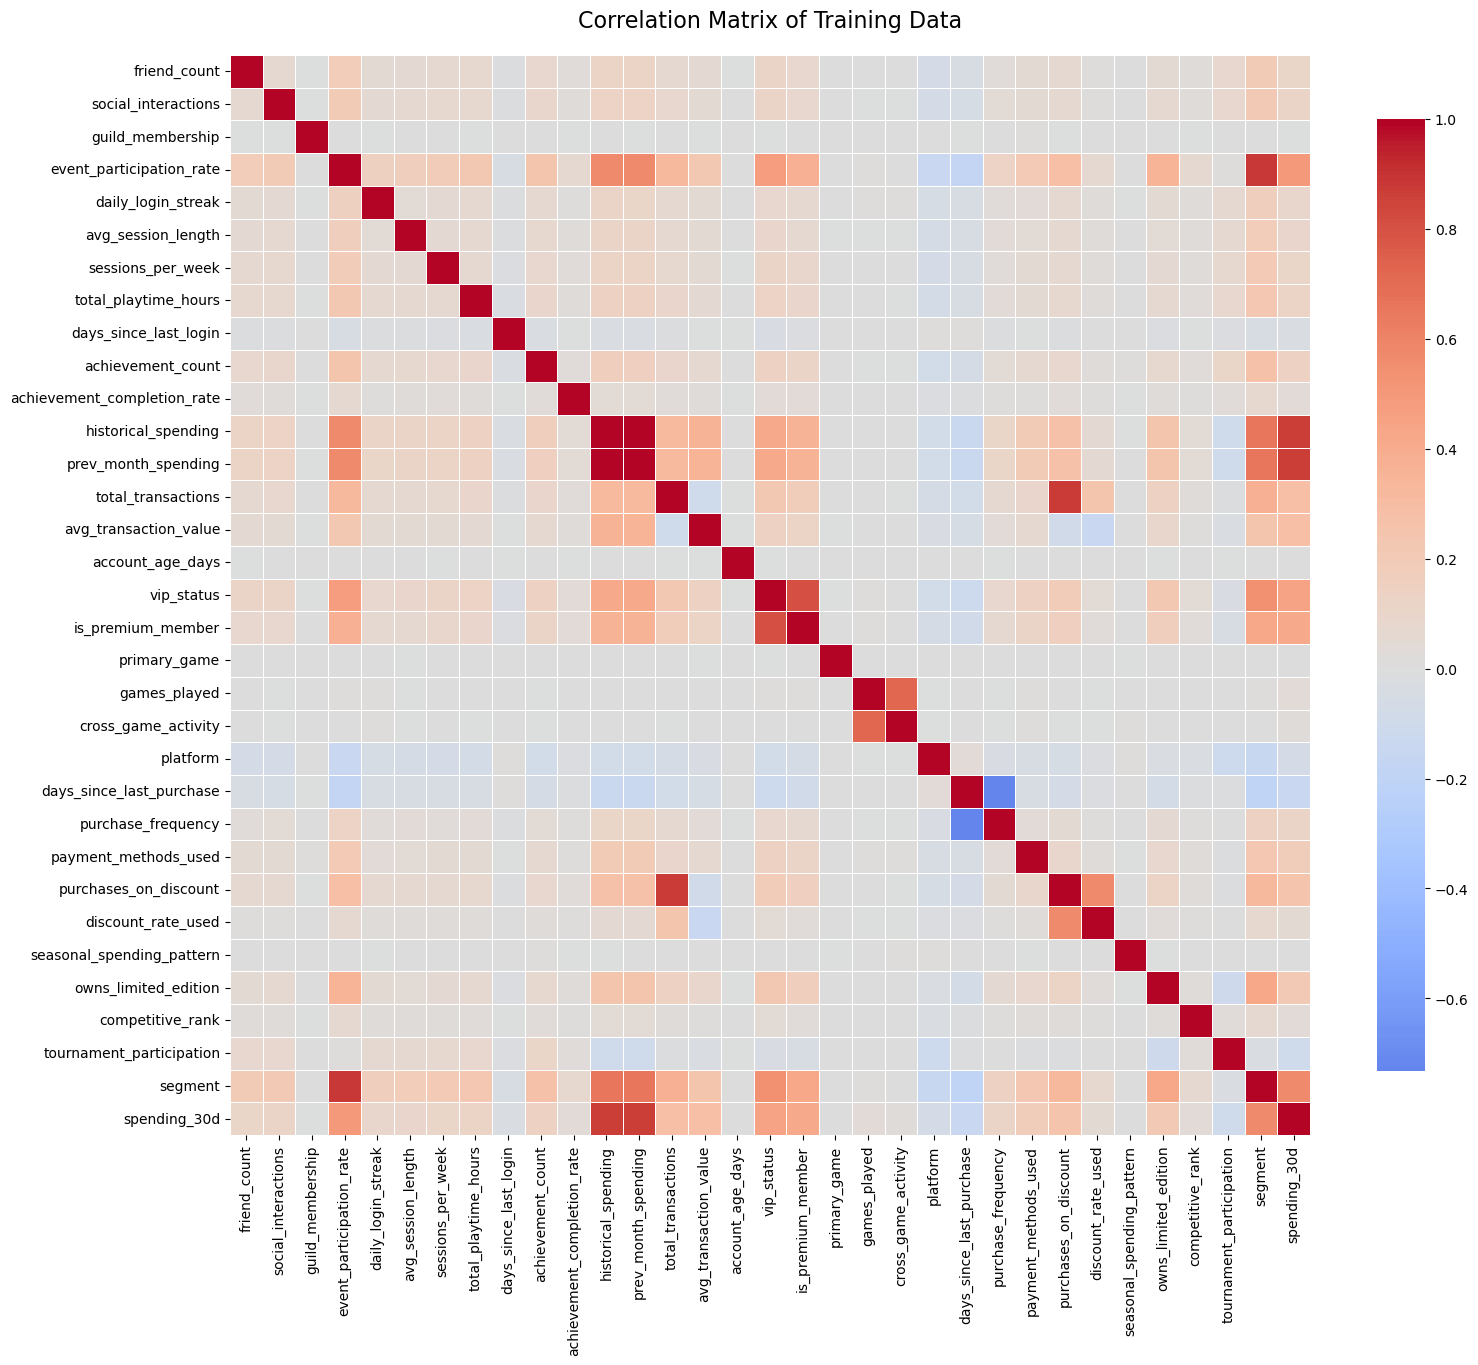

In [ ]:
corr_matrix = train_df.drop(columns=["id", "player_id"]).corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Training Data', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

Note:

- ลบ feature ที่ correlation สูงกว่า 0.9 ออก [prev_month_spending, historical_spending]

# สรุป EDA และสิ่งที่ต้องทำต่อ

- Handle missing values:
  -  Simple Imputer (median), KNN Imputer, Iterative Imputer <- ต้องทดลอง
-  Log Transform on [historical_spending, prev_month_spending, avg_transaction_value]
-  Log Transform on target (spending_30d) log1p
-  ลบ feature ที่ correlation สูงกว่า 0.9 ออก [prev_month_spending, historical_spending]
-  Encode categorical (one-hot)
-  Scaler (RobustScaler)
-  Feature Engineering:
   -  Cyclical encoding on seasonal_spending_pattern
   -  more ..